In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torchvision.transforms import v2
from einops import einsum


ENCODER_TYPE = "B6" #  B0 or B6

if ENCODER_TYPE == "B6":
    INPUT_SIZE = 528 # for encoder B6, INPUT_SIZE = 528, k_dim=8195, input_dim=4, hidden=1024, output_dim=3
    k_dim = 8195
    hidden = 1024
if ENCODER_TYPE == "B0":
    INPUT_SIZE = 256 # for encoder B0, INPUT_SIZE = 256, k_dim=515, input_dim=4, hidden=64, output_dim=3
    k_dim = 515
    hidden = 64


def enc_preprocess(pil_image, crop=False, image=False, rand_trans=False):
    im = pil_image
    im_size = (INPUT_SIZE, INPUT_SIZE)
    enc_shape = (3, INPUT_SIZE, INPUT_SIZE)  #  (1, 3, INPUT_SIZE, INPUT_SIZE)
    # v2 currently accepts only PIL Images
    if crop:
        crop = min(im.size)
        im = v2.CenterCrop(crop)(im)
    im = v2.Resize(im_size)(im)
    if rand_trans:
        im = v2.RandomHorizontalFlip(p=0.5)(im)
        im = v2.functional.rotate(im, angle=np.random.choice([0, 90, -90, 180]))
    if image:
        return im
    im = np.array(im, dtype=np.float32) / 255
    im = im.reshape(enc_shape)
    return torch.tensor(im)


class Encoder(nn.Module):
    
    def __init__(self, k_dim, input_dim, hidden, output_dim, device, encoder_type="B6"):
        super().__init__()
        self.k_dim = k_dim
        if encoder_type == "B6":
            self.model = torchvision.models.efficientnet_b6(num_classes=k_dim)
            self.resize = torchvision.models.efficientnet.EfficientNet_B6_Weights.IMAGENET1K_V1.transforms()  # INPUT_SIZE = 528
        elif encoder_type == "B0":
            self.model = torchvision.models.efficientnet_b0(num_classes=k_dim)
            self.resize = torchvision.models.efficientnet.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()  # INPUT_SIZE = 256
        

        self.device = device
#       # in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, 
#       # self.conv = nn.Conv2d(6, 3, (3, 3), stride=1, padding=1)
        
        self.input_dim = input_dim 
        self.hidden = hidden
        self.output_dim = output_dim
        self.splits = [0,
          input_dim * hidden, 
          input_dim * hidden + hidden, 
          input_dim * hidden + hidden + output_dim * hidden,
          input_dim * hidden + hidden + output_dim * hidden + output_dim,
         ]
        self.to(device)
        
    def forward(self, im1):
        # the input should be [batch_size, channels, height, width]
        with torch.no_grad():
            im1 = self.resize(im1)
        return self.model(im1)
    
    def apply_e(self, e, x, t):
        splits = self.splits
        batch_size = e.shape[0]
        shapes = [
          torch.Size([batch_size, self.hidden, self.input_dim]),
          torch.Size([batch_size, self.hidden]),
          torch.Size([batch_size, self.output_dim, self.hidden]),
          torch.Size([batch_size, self.output_dim]),
         ]
        # e = [batch_size, params_size]
        e0 = e[:, splits[0]:splits[1]].reshape(shapes[0])
        e1 = e[:, splits[1]:splits[2]].reshape(shapes[1])
        e2 = e[:, splits[2]:splits[3]].reshape(shapes[2])
        e3 = e[:, splits[3]:splits[4]].reshape(shapes[3])
        e1 = e1.unsqueeze(1)
        e3 = e3.unsqueeze(1)
        # x = [batch_size, sample_size, channels]
        # t = [batch_size, sample_size, 1]
        xt = torch.cat([x, t], dim=-1)
        xt = einsum(xt, e0, 'i j k, i n k -> i j n') + e1
        xt = torch.tanh(xt)
        xt = einsum(xt, e2, 'i j k, i n k -> i j n') + e3
        return xt

def run_inference_modflows(encoder, device, content_im, style_im, 
                  compress=False, enc_steps=8, strength=1.0, crop=False, verbose=False):
    with torch.no_grad():
        encoder.eval()
        
        if crop:
            content_im = v2.CenterCrop(min(content_im.size))(content_im)
            style_im = v2.CenterCrop(min(style_im.size))(style_im)
        
        base_im = enc_preprocess(content_im, crop).to(device)
        base_im = base_im.unsqueeze(0)
        base_e = encoder(base_im).flatten()
        base_encoded_flow = NeuralODE(input_dim=3, hidden=encoder.hidden, device=device)
        base_encoded_flow.set_weights(base_e)
        
        targ_im = enc_preprocess(style_im, crop).to(device)
        targ_im = targ_im.unsqueeze(0)
        targ_e = encoder(targ_im).flatten()
        targ_encoded_flow = NeuralODE(input_dim=3, hidden=encoder.hidden, device=device)
        targ_encoded_flow.set_weights(targ_e)
        
        w = content_im.width
        h = content_im.height

        if compress:
            w = int(w / compress)
            h = int(h / compress)
            content_im = content_im.resize((w, h)) 
        if verbose:
            print(f"im size: {w, h}")
        
        base_x = np.array(content_im, dtype=np.float32) / 255
        base_x = base_x.reshape(w * h, 3)
        base_x = torch.tensor(base_x).to(device)
        
        latent_x = base_encoded_flow.sample(base_x, N=enc_steps, strength=strength)
        styled_x = targ_encoded_flow.inv_sample(latent_x, N=enc_steps, strength=strength)
        
        latent_im = tensor_to_im(latent_x, w, h)
        styled_im = tensor_to_im(styled_x, w, h)
        return styled_im


class NeuralODE(nn.Module):
    
    def __init__(self, input_dim, device, hidden=32):
        super().__init__()
        self.device = device
        self.hidden = hidden
        self.input_dim = input_dim + 1
        self.output_dim = input_dim
        self.activation = nn.Tanh()
        self.layer_1 = nn.Linear(self.input_dim, self.hidden, bias=1)
        self.layer_2 = nn.Linear(self.hidden, self.output_dim, bias=1)
        self.shapes = [
          self.layer_1.weight.shape,
          self.layer_1.bias.shape,
          self.layer_2.weight.shape,
          self.layer_2.bias.shape,
         ]
        self.splits = [0,
          self.input_dim * hidden, 
          self.input_dim * hidden + hidden, 
          self.input_dim * hidden + hidden + self.output_dim * hidden,
          self.input_dim * hidden + hidden + self.output_dim * hidden + self.output_dim,
         ]
        self.total_params = sum(p.numel() for p in self.parameters())
        self.to(self.device)
        
    def set_weights(self, e):
        assert len(e) == self.total_params
        splits = self.splits
        shapes = self.shapes
        e0 = e[splits[0]:splits[1]].reshape(shapes[0])
        e1 = e[splits[1]:splits[2]].reshape(shapes[1])
        e2 = e[splits[2]:splits[3]].reshape(shapes[2])
        e3 = e[splits[3]:splits[4]].reshape(shapes[3])
        mask_dict = {
            'layer_1.weight': e0,
            'layer_1.bias': e1,
            'layer_2.weight': e2,
            'layer_2.bias': e3
        }
        self.load_state_dict(mask_dict)
        self.to(self.device)

    def forward(self, x, t):
        xt = torch.cat([x, t], dim=1)
        xt = self.layer_1(xt)
        xt = self.activation(xt)
        xt = self.layer_2(xt)
        return xt

    @torch.no_grad()
    def sample(self, x0, N=10_000, strength=1.0):
        sample_size = len(x0) 
        z = x0.detach().clone()
        dt = 1.0 / N
        for i in range(N):
            t = torch.ones((sample_size, 1)) * i / N
            t = t.to(self.device)
            z = z.to(self.device)
            pred = self.forward(z, t)
            
            #eps = 0.03
            #noise = torch.randn_like(pred)
            #z = z.detach().clone() + pred * dt + eps*noise*torch.sqrt(t*(1-t))

            z = z.detach().clone() + pred * dt
            if i > int(strength * N):
                break
        return z.detach().clone()

    @torch.no_grad()
    def inv_sample(self, x0, N=10_000, strength=1.0):
        sample_size = len(x0)
        z = x0.detach().clone()
        dt = 1.0 / N
        for i in range(N):
            t = torch.ones((sample_size, 1)) * i / N
            t = t.to(self.device)
            z = z.to(self.device)
            pred = self.forward(z, t)
            z = z.detach().clone() - pred * dt
            if i > int(strength * N):
                break
        return z.detach().clone()

def tensor_to_im(tensor, w, h):
    tensor = tensor.detach().cpu()
    tensor = torch.clip(tensor, 0, 1)
    tensor = tensor.reshape((h, w, 3)) * 255
    array = np.array(tensor, dtype=np.uint8)
    return Image.fromarray(array)

Upload pretrained encoder checkpoints by running:
```
    git clone https://huggingface.co/MariaLarchenko/modflows_color_encoder
```

You can select the model type by setting variable ``ENCODER_TYPE`` in the beggining of the notebook

In [2]:
if ENCODER_TYPE == "B6":
    #enc_path = "modflows_color_encoder/modflows_color_encoder_B6_dim_8195_iter_700000.pt"
    enc_path = "modflows_color_encoder/modflows_color_encoder_B6_dim_8195_iter_751001.pt"
elif ENCODER_TYPE == "B0":
    enc_path = "modflows_color_encoder/modflows_color_encoder_B0_dim_515.pt"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(k_dim=k_dim, input_dim=4, hidden=hidden, output_dim=3, device=device, encoder_type=ENCODER_TYPE)
enc_params = torch.load(enc_path, map_location=device)
encoder.load_state_dict(enc_params)

/tmp/ipykernel_1234478/3770810953.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  enc_params = torch.load(enc_path, map_location=device)


<All keys matched successfully>

In [3]:
from PIL import Image

content_im = Image.open("img/4.jpg")
style_im = Image.open("img/2.jpg")

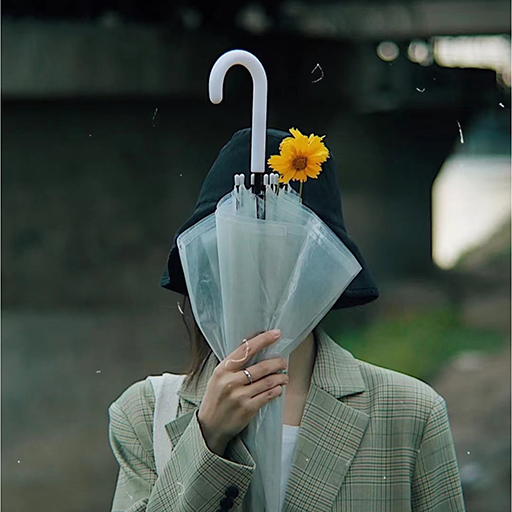

In [4]:
content_im

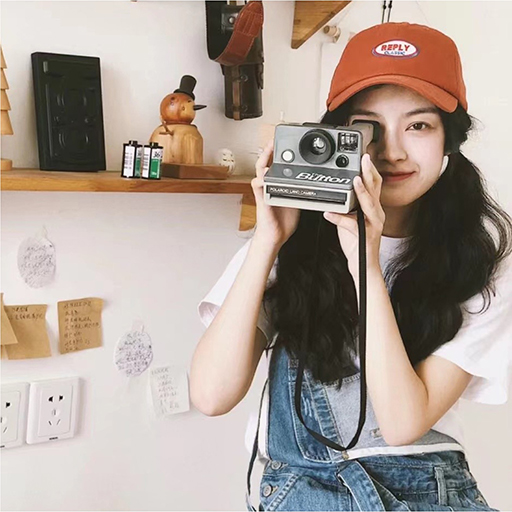

In [5]:
style_im

Here, the parameters of inference can be adjusted. We do not recommend setting the number of `enc_steps` below 8. The `strength` parameter controls the intensity of the color transfer and can range from 0.0 to 1.0.

In [6]:
styled_im = run_inference_modflows(encoder, device, content_im, style_im, enc_steps=10, strength=0.95)

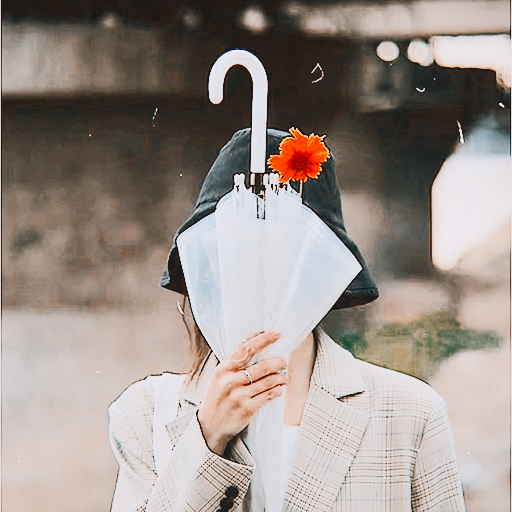

In [7]:
styled_im